In [42]:
import os

os.environ["OMP_NUM_THREAD"]="2"

In [43]:
import torch
from torch.nn import CrossEntropyLoss
from torch import optim 
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
from utils_datasets import MetaDistribution, RealDistribution
from utils_models import SimpleNetwork

In [45]:
meta = MetaDistribution(
    d=50,
    n_cluster=100,
    a_pareto_pi=2.0,
    a_pareto_sigma=2.0,
    scale_pareto_sigma=0.05
)

In [46]:
real_distribution = RealDistribution.from_meta(meta)

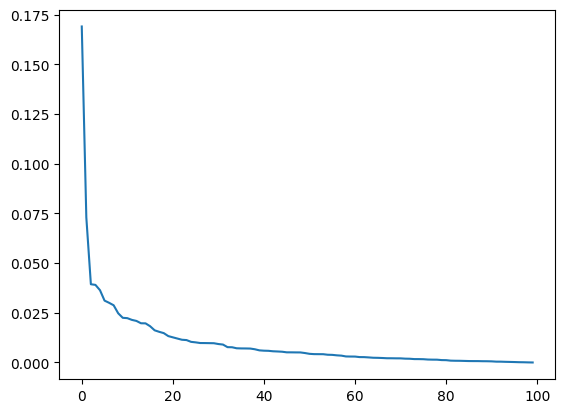

In [47]:
plt.plot(real_distribution.pi_0)
plt.show()

In [48]:
labels_train, cluster_idx_train, X_train = real_distribution.sample_points(500)
labels_test, cluster_idx_test, X_test = real_distribution.sample_points(2000)

(-2.5, 2.5)

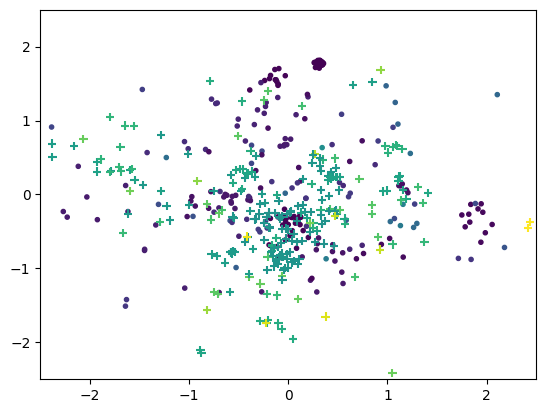

In [49]:
plt.scatter(X_train[labels_train == 0, 0], X_train[labels_train == 0, 1], c=cluster_idx_train[labels_train==0], marker=".", vmin=0, vmax=cluster_idx_train.max())
plt.scatter(X_train[labels_train == 1, 0], X_train[labels_train == 1, 1], c=cluster_idx_train[labels_train==1], marker="+", vmin=0, vmax=cluster_idx_train.max())
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

(-2.5, 2.5)

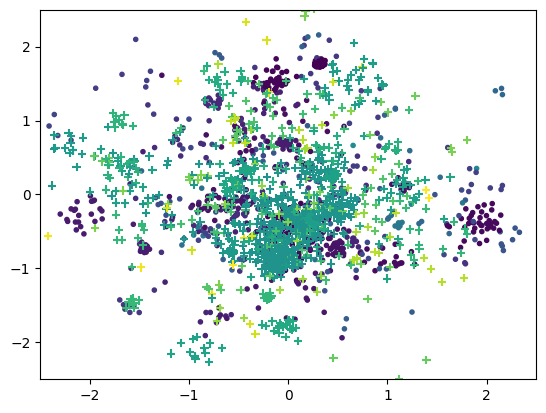

In [50]:
plt.scatter(X_test[labels_test == 0, 0], X_test[labels_test == 0, 1], c=cluster_idx_test[labels_test==0], marker=".", vmin=0, vmax=cluster_idx_test.max())
plt.scatter(X_test[labels_test == 1, 0], X_test[labels_test == 1, 1], c=cluster_idx_test[labels_test==1], marker="+", vmin=0, vmax=cluster_idx_test.max())
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

In [51]:
EPOCH = 5
N_LAYER = 0
TRAIN_BS = 4
TEST_BS = 100
device = torch.device("cuda")

In [52]:
model = SimpleNetwork(N_LAYER, real_distribution.d).to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [53]:
# fig = model.get_decision_boundaries_fig(X_train, labels_train)
# fig.show()

In [54]:
X_train = X_train.to(device)
X_test = X_test.to(device)

for epoch in range(EPOCH):

    # Train
    model.train()
    num_batch = X_train.shape[0] // TRAIN_BS
    for batch_idx in range(num_batch):
        optimizer.zero_grad()
        inputs = X_train[batch_idx*TRAIN_BS: min((batch_idx+1)*TRAIN_BS, X_train.shape[0]),:]
        labels = labels_train[batch_idx*TRAIN_BS: min((batch_idx+1)*TRAIN_BS, X_train.shape[0])]
        outputs = model(inputs).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 32 == 0:
            print(f"Epoch [{epoch+1}/{EPOCH}], Batch [{batch_idx+1}/{num_batch}], Loss: {loss.item():.4f}")

    # Validation loop
    model.eval()
    num_batch = X_test.shape[0] // TEST_BS
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for batch_idx in tqdm(range(num_batch)):
            inputs = X_test[batch_idx*TEST_BS: min((batch_idx+1)*TEST_BS, X_test.shape[0]),:]
            labels = labels_test[batch_idx*TEST_BS: min((batch_idx+1)*TEST_BS, X_test.shape[0])]
            outputs = model(inputs).cpu()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = 100 * total_correct / total_samples
        print(f"Validation Accuracy: {accuracy:.2f}%")

print("Training complete!")

Epoch [1/5], Batch [1/125], Loss: 0.7928


Epoch [1/5], Batch [33/125], Loss: 0.7298
Epoch [1/5], Batch [65/125], Loss: 0.6099
Epoch [1/5], Batch [97/125], Loss: 0.6745


100%|██████████| 20/20 [00:00<00:00, 40.45it/s]


Validation Accuracy: 73.90%
Epoch [2/5], Batch [1/125], Loss: 0.5322
Epoch [2/5], Batch [33/125], Loss: 0.6400
Epoch [2/5], Batch [65/125], Loss: 0.6632
Epoch [2/5], Batch [97/125], Loss: 0.7003


100%|██████████| 20/20 [00:01<00:00, 20.00it/s]


Validation Accuracy: 75.30%
Epoch [3/5], Batch [1/125], Loss: 0.4333
Epoch [3/5], Batch [33/125], Loss: 0.5576
Epoch [3/5], Batch [65/125], Loss: 0.7114
Epoch [3/5], Batch [97/125], Loss: 0.7007


100%|██████████| 20/20 [00:00<00:00, 36.14it/s]


Validation Accuracy: 76.80%
Epoch [4/5], Batch [1/125], Loss: 0.3752
Epoch [4/5], Batch [33/125], Loss: 0.4933
Epoch [4/5], Batch [65/125], Loss: 0.7512
Epoch [4/5], Batch [97/125], Loss: 0.6896


100%|██████████| 20/20 [00:00<00:00, 25.16it/s]


Validation Accuracy: 77.50%
Epoch [5/5], Batch [1/125], Loss: 0.3374
Epoch [5/5], Batch [33/125], Loss: 0.4435
Epoch [5/5], Batch [65/125], Loss: 0.7840
Epoch [5/5], Batch [97/125], Loss: 0.6735


100%|██████████| 20/20 [00:01<00:00, 15.38it/s]

Validation Accuracy: 77.50%
Training complete!


In [55]:
model = SimpleNetwork(1, real_distribution.d).to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [56]:
X_train = X_train.to(device)
X_test = X_test.to(device)

for epoch in range(EPOCH):

    # Train
    model.train()
    num_batch = X_train.shape[0] // TRAIN_BS
    for batch_idx in range(num_batch):
        optimizer.zero_grad()
        inputs = X_train[batch_idx*TRAIN_BS: min((batch_idx+1)*TRAIN_BS, X_train.shape[0]),:]
        labels = labels_train[batch_idx*TRAIN_BS: min((batch_idx+1)*TRAIN_BS, X_train.shape[0])]
        outputs = model(inputs).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 32 == 0:
            print(f"Epoch [{epoch+1}/{EPOCH}], Batch [{batch_idx+1}/{num_batch}], Loss: {loss.item():.4f}")

    # Validation loop
    model.eval()
    num_batch = X_test.shape[0] // TEST_BS
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for batch_idx in tqdm(range(num_batch)):
            inputs = X_test[batch_idx*TEST_BS: min((batch_idx+1)*TEST_BS, X_test.shape[0]),:]
            labels = labels_test[batch_idx*TEST_BS: min((batch_idx+1)*TEST_BS, X_test.shape[0])]
            outputs = model(inputs).cpu()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = 100 * total_correct / total_samples
        print(f"Validation Accuracy: {accuracy:.2f}%")

print("Training complete!")

Epoch [1/5], Batch [1/125], Loss: 0.6956
Epoch [1/5], Batch [33/125], Loss: 0.6626
Epoch [1/5], Batch [65/125], Loss: 0.6514
Epoch [1/5], Batch [97/125], Loss: 0.7624


100%|██████████| 20/20 [00:00<00:00, 99.44it/s]


Validation Accuracy: 64.85%
Epoch [2/5], Batch [1/125], Loss: 0.5638
Epoch [2/5], Batch [33/125], Loss: 0.6771
Epoch [2/5], Batch [65/125], Loss: 0.6476
Epoch [2/5], Batch [97/125], Loss: 0.7468


100%|██████████| 20/20 [00:00<00:00, 50.54it/s] 


Validation Accuracy: 70.05%
Epoch [3/5], Batch [1/125], Loss: 0.5001
Epoch [3/5], Batch [33/125], Loss: 0.6936
Epoch [3/5], Batch [65/125], Loss: 0.6591
Epoch [3/5], Batch [97/125], Loss: 0.7472


100%|██████████| 20/20 [00:01<00:00, 16.72it/s]


Validation Accuracy: 72.00%
Epoch [4/5], Batch [1/125], Loss: 0.4527
Epoch [4/5], Batch [33/125], Loss: 0.7049
Epoch [4/5], Batch [65/125], Loss: 0.6756
Epoch [4/5], Batch [97/125], Loss: 0.7543


100%|██████████| 20/20 [00:00<00:00, 33.48it/s]


Validation Accuracy: 72.85%
Epoch [5/5], Batch [1/125], Loss: 0.4154
Epoch [5/5], Batch [33/125], Loss: 0.7113
Epoch [5/5], Batch [65/125], Loss: 0.6940
Epoch [5/5], Batch [97/125], Loss: 0.7647


100%|██████████| 20/20 [00:00<00:00, 33.27it/s]

Validation Accuracy: 73.55%
Training complete!
